In [1]:
import numpy as np
import pandas as pd
import pymysql as mdb
import sklearn as sk
import sqlalchemy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# connect to database
con = mdb.connect('localhost','root','','runnersdb')
cur = con.cursor()
sqlEngine = sqlalchemy.create_engine('mysql+pymysql://root@localhost/runnersdb')

In [23]:
# load list of marathon runners from database
runners = pd.read_sql("SELECT * FROM runners WHERE age > 0;",con)
success = pd.DataFrame((runners['goal']-runners['time'])/runners['goal']*100)
runners = pd.concat([runners, success], axis=1)
runners = runners.rename(columns = {0:'marathon_success','time':'marathon_time','pace':'marathon_pace','date':'marathon_date','start_time':'marathon_start_time','activity':'marathon_activity','goal':'marathon_goal'})

# load all training activities
log = pd.read_sql("SELECT * FROM updated_log;",con)
log[['user']] = log[['user']].astype(int)
log[['run_distance','run_pace']] = log[['run_distance','run_pace']].astype(float)

In [24]:
# join list of runners with activities
joined_data = pd.merge(runners,log,on='user')
run_stress = joined_data['run_distance']/26.2*(joined_data['marathon_pace']/joined_data['run_pace'])*(joined_data['marathon_pace']/joined_data['run_pace'])
joined_data = pd.concat([joined_data,run_stress],axis='1')
joined_data = joined_data.rename(columns = {0:'run_stress'})
del joined_data['index']
cur.execute("DROP TABLE IF EXISTS full_log")
joined_data.to_sql('full_log',sqlEngine)

In [25]:
# convert date to days before marathon
run_dates = pd.to_datetime(joined_data['run_date'])
marathon_dates = pd.to_datetime(joined_data['marathon_date'])
days_to_marathon = (run_dates - marathon_dates).astype(int)/60/60/24/1000000000
joined_data = pd.concat([joined_data,days_to_marathon],axis='1')
joined_data = joined_data.rename(columns = {0:'days_to_marathon'})

In [26]:
# trim dataset to before the marathon
close_day = -24
far_day = -94
before_marathon = joined_data[(joined_data['days_to_marathon']<close_day) & (joined_data['days_to_marathon']>far_day)]
cur.execute("DROP TABLE IF EXISTS before_marathon")
before_marathon.to_sql('before_marathon',sqlEngine)

In [27]:
# a is activities -2 to -14 week data
a = pd.read_sql("SELECT user, race, marathon_success,run_stress,days_to_marathon, marathon_pace, run_pace FROM before_marathon WHERE run_stress < 10;",con)
a = a.drop_duplicates()
cur.execute("DROP TABLE IF EXISTS before_marathon_small")
a.to_sql("before_marathon_small",sqlEngine)

# b sums up all multiple activities on one day
b = pd.read_sql("SELECT user, race, marathon_success,SUM(run_stress),(marathon_pace/run_pace),days_to_marathon FROM before_marathon_small GROUP BY user,race,days_to_marathon;",con)
b = b.rename(columns = {'SUM(run_stress)':'run_stress','(marathon_pace/run_pace)':'intensity'})
cur.execute("DROP TABLE IF EXISTS before_marathon_small_2")
b.to_sql("before_marathon_small_2",sqlEngine)

In [28]:
# break up run stress into run difficulty 
# quantiles are correspond to roughly 0, 5, 8, 13, 18
c = pd.read_sql("SELECT * FROM before_marathon_small_2",con)
del c['index']
difficulty = pd.DataFrame(pd.qcut(c.run_stress,q=[0,0.25,0.52,0.75,1],labels=[1,2,3,4]))
difficulty = difficulty.rename(columns = {'run_stress':'run_difficulty'})
c = pd.concat([c,difficulty],axis='1')
c['run_difficulty'] = c['run_difficulty'].astype(int)

In [29]:
intensity = c[['intensity','run_difficulty']]
cur.execute("DROP TABLE IF EXISTS intensity")
intensity.to_sql("intensity",sqlEngine)

In [30]:
# adds in missing days with 0 run difficulty
grouped = c.groupby(by=['user','race','marathon_success'])
userlist = []
for (u,r,m), group in grouped:
    df = grouped.get_group((u,r,m))
    start = df.set_index('days_to_marathon').first_valid_index()
    stop = df.set_index('days_to_marathon').last_valid_index()
    dfleft = df.set_index('days_to_marathon')[['user','race','marathon_success']].reindex(index=np.arange(start,stop+1), method='pad')
    dfright = df.set_index('days_to_marathon')[['run_stress','run_difficulty']].reindex(index=np.arange(start,stop+1))
    userlist.append(pd.concat([dfleft,dfright],axis=1))
d = pd.concat(userlist,axis=0)
d.fillna(value=0,inplace=True)
# d = d[d['run_difficulty'] < 5]

In [31]:
# c = pd.read_sql("SELECT SUM(run_stress),days_to_marathon FROM before_marathon_small_2 GROUP BY days_to_marathon;",con)
# c = c.rename(columns = {'SUM(run_stress)':'run_stress'})
# c.plot(kind='line',x='days_to_marathon',y='run_stress')
# # plt.plot(c['days_to_marathon'],c['run_stress'],'bo')
# plt.xlabel('Days to marathon')
# plt.ylabel('Combined stress')

In [32]:
# good = joined_data[joined_data['marathon_success'] > joined_data['marathon_success'].median()]
# bad = joined_data[joined_data['marathon_success'] < joined_data['marathon_success'].median()]

In [33]:
good = d[d['marathon_success'] > d['marathon_success'].median()]
bad = d[d['marathon_success'] < d['marathon_success'].median()]

In [34]:
cur.execute("DROP TABLE IF EXISTS good_runners")
good.to_sql("good_runners",sqlEngine)
cur.execute("DROP TABLE IF EXISTS bad_runners")
bad.to_sql("bad_runners",sqlEngine)

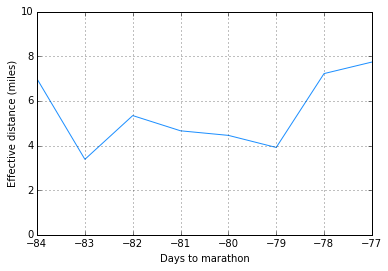

In [26]:
# plot training pattern before marathon
# fig,ax = plt.subplots()
good_mod = pd.read_sql("SELECT AVG(run_stress),days_to_marathon FROM good_runners GROUP BY days_to_marathon;",con)
good_mod = good_mod.rename(columns = {'AVG(run_stress)':'run_stress'})
good_mod = good_mod[-60:-52]
good_mod['run_stress'] = good_mod['run_stress']*26.2
bad_mod = pd.read_sql("SELECT AVG(run_stress),days_to_marathon FROM bad_runners GROUP BY days_to_marathon;",con)
bad_mod = bad_mod.rename(columns = {'AVG(run_stress)':'run_stress'})
good_mod.plot(kind='line',x='days_to_marathon',y='run_stress',color='dodgerblue',legend=False,ylim=(0,10))
# bad_mod.plot(kind='line',x='days_to_marathon',y='run_stress',color='dodgerblue',legend=True,ylim=(0,1),ax=ax)
plt.xlabel('Days to marathon')
plt.ylabel('Effective distance (miles)')
# plt.legend(['goal achievers','non-goal achievers'])

In [22]:
good_mod[-67:-60]

,run_stress,days_to_marathon
2,8.164139,-91
3,4.136697,-90
4,5.186816,-89
5,4.210174,-88
6,4.521747,-87
7,4.145788,-86
8,6.276680,-85


In [42]:
diff = pd.DataFrame()
for i in xrange(close_day-far_day):
    diff = diff.append([[close_day-far_day-i,0]])
diff = diff.rename(columns = {0:'days_to_marathon',1:'difficulty'})

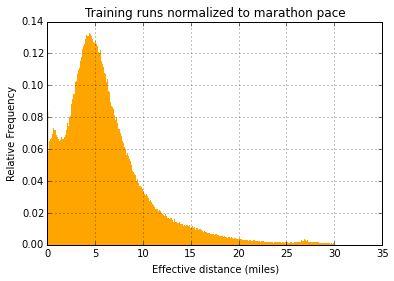

In [43]:
(joined_data.run_stress*26.2).hist(bins=300,range=(0,30),normed=1,edgecolor='none',color='orange')
plt.xlabel('Effective distance (miles)')
plt.ylabel('Relative Frequency')
plt.title('Training runs normalized to marathon pace')

In [44]:
# Create testset
close_test = -10
far_test = -24
before_marathon_t = joined_data[(joined_data['days_to_marathon']<close_test) & (joined_data['days_to_marathon']>far_test)]

# a is activities -2 to -14 week data
before_marathon_t = before_marathon_t[before_marathon_t['run_stress']<10]
before_marathon_t = before_marathon_t.drop_duplicates()
cur.execute("DROP TABLE IF EXISTS before_marathon_t")
before_marathon_t.to_sql("before_marathon_t",sqlEngine)

# b sums up all multiple activities on one day
b_t = pd.read_sql("SELECT user, race, marathon_success,SUM(run_stress),days_to_marathon FROM before_marathon_t GROUP BY user,race,days_to_marathon;",con)
b_t = b_t.rename(columns = {'SUM(run_stress)':'run_stress'})

# break up run stress into run difficulty 
# quantiles are correspond to roughly 0, 5, 8, 13, 18
difficulty_t = pd.DataFrame(pd.cut((b_t.run_stress*26.2),[0,5.085,8.059,12.8,400],labels=[1,2,3,4]))
difficulty_t = difficulty_t.rename(columns = {'run_stress':'run_difficulty'})
b_t = pd.concat([b_t,difficulty],axis='1')
b_t['run_difficulty'] = b_t['run_difficulty'].astype(int)

# 
grouped = b_t.groupby(by=['user','race','marathon_success'])
userlist = []
for (u,r,m), group in grouped:
    df = grouped.get_group((u,r,m))
    start = df.set_index('days_to_marathon').first_valid_index()
    stop = df.set_index('days_to_marathon').last_valid_index()
    dfleft = df.set_index('days_to_marathon')[['user','race','marathon_success']].reindex(index=np.arange(start,stop+1), method='pad')
    dfright = df.set_index('days_to_marathon')[['run_stress','run_difficulty']].reindex(index=np.arange(start,stop+1))
    userlist.append(pd.concat([dfleft,dfright],axis=1))
d_t = pd.concat(userlist,axis=0)
d_t.fillna(value=0,inplace=True)
# # d = d[d['run_difficulty'] < 5]

In [45]:
cur.execute("DROP TABLE IF EXISTS test_set")
d_t.to_sql("test_set",sqlEngine)

In [51]:
intensity.run_difficulty

AttributeError: 'DataFrame' object has no attribute 'run_difficulty'

In [6]:
# difficulty = pd.DataFrame(pd.qcut(c.run_stress,q=[0,0.25,0.5,0.75,0.9,1],labels=[1,2,3,4]))
# difficulty = difficulty.rename(columns = {'run_stress':'run_difficulty'})

In [104]:
quants = []
divs = 20
for i in xrange(divs):
    print c['run_stress'].quantile(float(i)/divs)*26.2
    quants.append([float(i)/20,c['run_stress'].quantile(float(i)/20)*26.2])
quants = pd.DataFrame(quants)

0.0
2.50095735226
3.44141185514
4.08634308082
4.61957848024
5.10604731024
5.59865983097
6.11245401361
6.64004880875
7.2095104522
7.81563037813
8.51229058239
9.31375964311
10.251557054
11.4479219424
12.9287261416
14.7551619153
16.9057074724
19.8908445647
26.8963986612


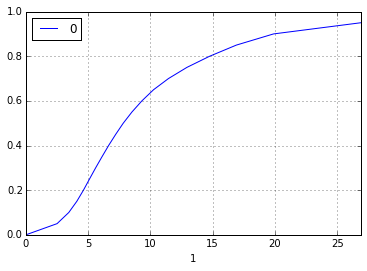

In [105]:
quants.plot(x=1,y=0)

In [104]:
# run_dates = pd.to_datetime((full_data['run_date']+' '+full_data['run_time']))
# marathon_dates = pd.to_datetime((full_data['marathon_date']+' '+full_data['marathon_start_time']))
# days_to_marathon = run_dates - marathon_dates

In [118]:
# more = pd.concat([full_data, days_to_marathon], axis=1)
# more = more.rename(columns = {0:'days_to_marathon'})

In [9]:
# more['days_to_marathon'][0]=days_to_marathon[0]

In [29]:
before_marathon2

NameError: name 'before_marathon2' is not defined

In [5]:
good_mod[-66:-38].plot(kind='line',x='days_to_marathon',y='run_stress')

NameError: name 'good_mod' is not defined

In [276]:
weekday = good_mod[-66:-38]['days_to_marathon']%7

In [277]:
holder = good_mod[-66:-38].reset_index()

In [278]:
weekday = weekday.reset_index()
del weekday['index']

In [279]:
weekday = weekday.rename(columns = {'days_to_marathon':'weekday'})

In [284]:
mod = pd.concat([holder, weekday], axis=1)
del mod['index']
del mod['days_to_marathon']

mod

In [294]:
# cur.execute("DROP TABLE IF EXISTS good_runners")
# good.to_sql("good_runners",sqlEngine)
# cur.execute("DROP TABLE IF EXISTS bad_runners")
# bad.to_sql("bad_runners",sqlEngine)
cur.execute("DROP TABLE IF EXISTS modu")
mod.to_sql("modu",sqlEngine)

/Users/Eddie/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Unknown table 'runnersdb.modu'
  result = self._query(query)


In [15]:
modu = pd.read_sql("SELECT AVG(run_stress),weekday FROM modu GROUP BY weekday",con)

In [16]:
modu = modu.rename(columns = {'AVG(run_stress)':'stress'})

In [17]:
modu['stress'] = modu['stress']*26.2
modu

,stress,weekday
0,12.444128,0
1,8.105098,1
2,8.989077,2
3,8.576705,3
4,8.060092,4
5,10.380394,5
6,12.413208,6


In [3]:
cur.execute("DROP TABLE IF EXISTS week_stress")
modu.to_sql("week_stress",sqlEngine)

NameError: name 'modu' is not defined

In [10]:
import datetime

In [11]:
datetime.datetime.today().weekday()

0

In [12]:
day_names = pd.DataFrame(['Sun','Mon','Tues','Weds','Thurs','Fri','Sat'])

In [13]:
modu_new = pd.concat([modu,day_names],axis=1)
modu_new = modu_new.rename(columns = {0:'day'})

modu_new

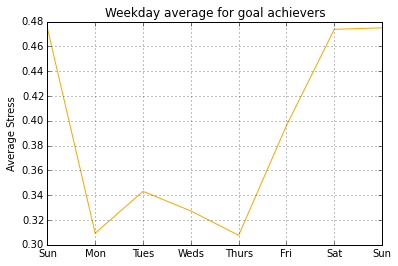

In [394]:
modu_new.plot(kind='line',x='day',y='stress',legend=False,color = 'orange')
plt.xlabel('')
plt.ylabel('Average Stress')
plt.title('Weekday average for goal achievers')

In [370]:
add_me = pd.DataFrame([[modu_new.stress[0],modu_new.weekday[0],modu_new.day[0]]])
add_me = add_me.rename(columns = {0:'stress',1:'weekday',2:'day'})

In [371]:
modu_new = modu_new.append(add_me)

In [372]:
modu_new

,stress,weekday,day
0,0.474967,0,Sun
1,0.309355,1,Mon
2,0.343095,2,Tues
3,0.327355,3,Weds
4,0.307637,4,Thurs
5,0.396198,5,Fri
6,0.473787,6,Sat
0,0.474967,0,Sun


In [358]:
add_me

,stress,weekday,day
0,0.474967,0,Sunday


In [49]:
import pymc

ImportError: dlopen(/Users/Eddie/anaconda/lib/python2.7/site-packages/scipy/special/_ufuncs.so, 2): Library not loaded: /usr/local/lib/gcc/4.9/libgfortran.3.dylib
  Referenced from: /Users/Eddie/anaconda/lib/python2.7/site-packages/scipy/special/_ufuncs.so
  Reason: image not found

In [102]:
good

,user,race,marathon_success,run_stress,run_difficulty
days_to_marathon,,,,,
-78,1535,Boston Marathon,0.291667,0.025345,1.000000e+00
-77,1535,Boston Marathon,0.291667,0.443394,3.000000e+00
-76,1535,Boston Marathon,0.291667,0.154642,1.000000e+00
-75,1535,Boston Marathon,0.291667,0.272283,2.000000e+00
-74,1535,Boston Marathon,0.291667,0.675866,4.000000e+00
-73,1535,Boston Marathon,0.291667,0.000000,0.000000e+00
-72,1535,Boston Marathon,0.291667,0.480314,3.000000e+00
-71,1535,Boston Marathon,0.291667,0.474229,3.000000e+00
-70,1535,Boston Marathon,0.291667,0.000000,0.000000e+00
